In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd /notebooks/

/notebooks


In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from tqdm.notebook import trange, tqdm
from digital_twin_library import SubsetSampler, corr
import seaborn as sns


# Train our first linear model

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
from neuralpredictors.data.datasets import FileTreeDataset

root_dir = 'data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6'
dat = FileTreeDataset(root_dir, 'images', 'responses')
dat

FileTreeDataset /notebooks/data/static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6 (n=5994 items)
	images, responses

In [6]:
train_sampler = SubsetSampler(dat.trial_info.tiers == 'train', shuffle=True)
test_sampler = SubsetSampler(dat.trial_info.tiers == 'test', shuffle=False)
val_sampler = SubsetSampler(dat.trial_info.tiers == 'validation', shuffle=False)

In [7]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dat, sampler=train_sampler, batch_size=64)
val_loader = DataLoader(dat, sampler=val_sampler, batch_size=64)
test_loader = DataLoader(dat, sampler=test_sampler, batch_size=64)

# Define a simple linear model

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the images
        return self.linear(x)

In [ ]:
model = LinearModel(36864, 8372)
model = model.to(device)
model

In [ ]:
loss = nn.MSELoss() # mean squared error loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 50
for epoch in range(epochs):
    model.train()
    for images, responses in tqdm(train_loader, desc='Training Set'):
        optimizer.zero_grad()
        
        images = images.to(device)
        responses = responses.to(device)
        outputs = model(images)
        mse = loss(outputs, responses)
        mse.backward()
        optimizer.step()

    resp, pred = [], []
    

    # set the model in validation state
    model.eval()
    for images, responses in tqdm(val_loader, desc='Validation Set'):
        images = images.to(device)
        responses = responses.to(device)
        outputs = model(images)
        resp.append(responses.cpu().detach().numpy())
        pred.append(outputs.cpu().detach().numpy())
    resp = np.vstack(resp)
    pred = np.vstack(pred)
    val_corr = corr(resp, pred, dim=0)
    print(f'Epoch [{epoch+1}/{epochs}], Validation orrelation: {val_corr.mean():.4f}')

# Train a slightly better model

In [8]:
from torchvision.transforms import Resize, Compose, ToTensor
class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.bn = nn.BatchNorm1d(input_dim)
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten the images
        return self.linear(self.bn(x))

In [31]:
img_size = (18, 32) #(36, 64)
resize = Resize(img_size)

model_xs = LinearModel(np.prod(img_size), 8372)
model_xs = model_xs.to(device)

loss = nn.MSELoss() # mean squared error loss
optimizer = torch.optim.Adam(model_xs.parameters(), lr=0.1, weight_decay=1e-4)

epochs = 30
for epoch in range(epochs):
    model_xs.train()
    for images, responses in train_loader:
        optimizer.zero_grad()
        
        images = resize(images).to(device)
        responses = responses.to(device)
        outputs = model_xs(images)
        mse = loss(outputs, responses)
        mse.backward()
        optimizer.step()

    if epoch % 5 == 0:
        # set the model in validation state
        resp, pred = [], []
        model_xs.eval()
        for images, responses in train_loader:
            images = resize(images).to(device)
            responses = responses.to(device)
            outputs = model_xs(images)
            resp.append(responses.cpu().detach().numpy())
            pred.append(outputs.cpu().detach().numpy())
        resp = np.vstack(resp)
        pred = np.vstack(pred)
        train_corr = corr(resp, pred, dim=0)

        resp, pred = [], []
        
        # set the model in validation state
        model_xs.eval()
        for images, responses in val_loader:
            images = resize(images).to(device)
            responses = responses.to(device)
            outputs = model_xs(images)
            resp.append(responses.cpu().detach().numpy())
            pred.append(outputs.cpu().detach().numpy())
        resp = np.vstack(resp)
        pred = np.vstack(pred)
        val_corr = corr(resp, pred, dim=0)
        print(f'Epoch [{epoch+1}/{epochs}], Validation correlation: {val_corr.mean():.4f}, Training correlation: {train_corr.mean():.4f}')

Epoch [1/30], Validation correlation: 0.1035, Training correlation: 0.1281
Epoch [2/30], Validation correlation: 0.1048, Training correlation: 0.1372
Epoch [3/30], Validation correlation: 0.1056, Training correlation: 0.1323
Epoch [4/30], Validation correlation: 0.1024, Training correlation: 0.1297


KeyboardInterrupt: 

## Plot the performance

In [26]:
model_xs.eval()
resp, pred = [], []

for images, responses in train_loader:
    images = resize(images).to(device)
    responses = responses.to(device)
    outputs = model_xs(images)
    resp.append(responses.cpu().detach().numpy())
    pred.append(outputs.cpu().detach().numpy())
resp = np.vstack(resp)
pred = np.vstack(pred)
train_corr = corr(resp, pred, dim=0)

In [27]:
model_xs.eval()
resp, pred = [], []

for images, responses in val_loader:
    images = resize(images).to(device)
    responses = responses.to(device)
    outputs = model_xs(images)
    resp.append(responses.cpu().detach().numpy())
    pred.append(outputs.cpu().detach().numpy())
resp = np.vstack(resp)
pred = np.vstack(pred)
val_corr = corr(resp, pred, dim=0)

<AxesSubplot:ylabel='Count'>

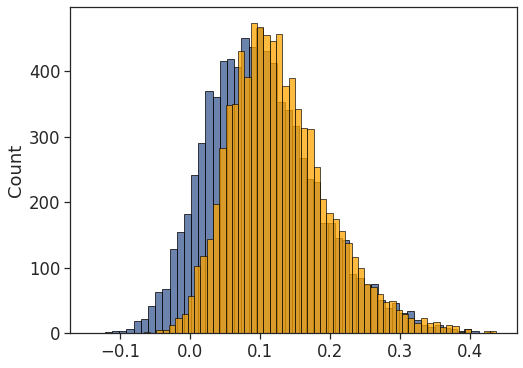

In [28]:
sns.set_context('notebook', font_scale=1.5)
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(8, 6))
sns.histplot(val_corr, kde=False, ax = ax, color=sns.xkcd_rgb['denim blue'], label='Validation')
sns.histplot(train_corr, kde=False, ax = ax, color='orange', label='Train')

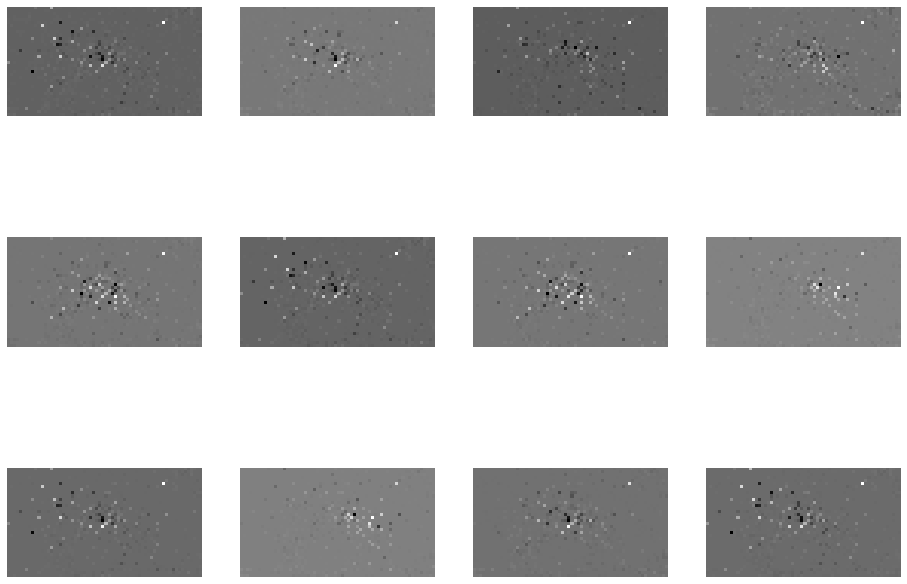

In [29]:
idx = np.argsort(-val_corr)
W = model_xs.linear.weight[idx[:12], :].detach().cpu().numpy()

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(3, 4, figsize=(16, 12))
    for a, w in zip(ax.ravel(), W):
        a.imshow(w.reshape(36, 64), cmap='gray')
        a.axis('off')